In [55]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import pandas as pd
import numpy as np
import requests
from keras.layers import Dense, LSTM
import math
import matplotlib.pyplot as plt

Загрузить данные

In [56]:
url = 'https://api.binance.com/api/v3/klines'
params = {
    'symbol': 'BTCUSDT',
    'interval': '1m',
    'limit': 1000
}

df = pd.DataFrame(requests.get(url, params=params).json())
df.to_csv('file.csv', index=False)

Преобразовать датафрейм

In [57]:
data = pd.DataFrame()
data['date'] = df.iloc[:, 0]
data['date'] = pd.to_datetime(data['date'], unit='ms')
data['open'] = df.iloc[:, 1].astype(float)
data['high'] = df.iloc[:, 2].astype(float)
data['low'] = df.iloc[:, 3].astype(float)
data['close'] = df.iloc[:, 4].astype(float)
data['vol_coins'] = df.iloc[:, 5].astype(float)
data['vol_dollars'] = df.iloc[:, 7].astype(float)
data['trades'] = df.iloc[:, 8].astype(float)
data['vol_market_coins'] = df.iloc[:, 9].astype(float)
data['vol_market_dollars'] = df.iloc[:, 10].astype(float)

In [58]:
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

data.head(10)

There are 1000 rows and 10 columns


,date,open,high,low,close,vol_coins,vol_dollars,trades,vol_market_coins,vol_market_dollars
0,2023-04-11 01:24:00,29780.00,29791.12,29779.99,29784.80,32.12676,9.568665e+05,662.0,18.39219,547773.399752
1,2023-04-11 01:25:00,29784.80,29793.60,29780.93,29793.59,27.56093,8.209121e+05,578.0,10.28826,306447.638614
2,2023-04-11 01:26:00,29793.59,29806.62,29793.59,29806.61,39.44536,1.175584e+06,593.0,25.53548,760984.735505
3,2023-04-11 01:27:00,29806.62,29810.75,29805.23,29806.62,54.49377,1.624286e+06,584.0,19.14203,570545.837320
4,2023-04-11 01:28:00,29806.63,29829.99,29806.59,29808.09,29.02959,8.656255e+05,1021.0,12.47146,371839.582911
5,2023-04-11 01:29:00,29808.09,29836.04,29808.08,29824.70,38.80040,1.157396e+06,949.0,12.64188,377048.655450
6,2023-04-11 01:30:00,29824.70,29860.30,29824.69,29860.30,37.66373,1.124074e+06,1169.0,26.00298,776083.278631
7,2023-04-11 01:31:00,29860.30,29862.50,29847.61,29859.49,43.17031,1.288897e+06,908.0,20.94898,625416.158535
8,2023-04-11 01:32:00,29859.50,29862.00,29841.72,29862.00,50.43633,1.505824e+06,877.0,19.69948,588126.977037
9,2023-04-11 01:33:00,29862.00,29865.65,29854.96,29865.64,35.25790,1.052911e+06,671.0,24.00891,716983.382171


Посмотреть зависимость стоимости криптовалюты от времени

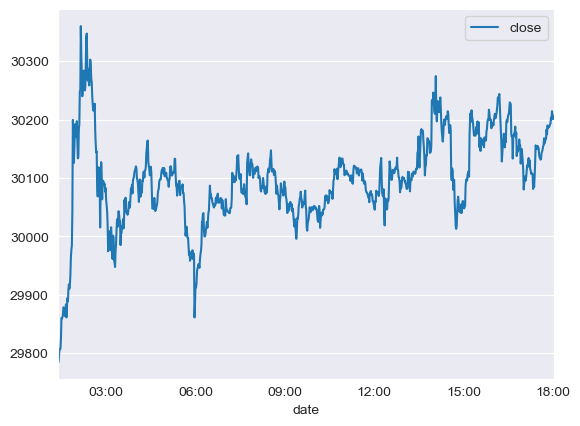

In [59]:
data.plot(x='date', y='close')
plt.show()

Посчитать пропуски в данных:

In [60]:
count = 0
for n in df.columns:
    if df[n].isnull().any() == True:
        count +=1

print(f'count = {count}')

count = 0


пропусков нет

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1000 non-null   datetime64[ns]
 1   open                1000 non-null   float64       
 2   high                1000 non-null   float64       
 3   low                 1000 non-null   float64       
 4   close               1000 non-null   float64       
 5   vol_coins           1000 non-null   float64       
 6   vol_dollars         1000 non-null   float64       
 7   trades              1000 non-null   float64       
 8   vol_market_coins    1000 non-null   float64       
 9   vol_market_dollars  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 78.2 KB


Предобработать тренировочную выборку

In [62]:
x_train = []
y_train = []

price = data['close']
values = price.values
train_len = math.ceil(len(values)* 0.94)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0:train_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Предобработать тестовую выборку

In [63]:
test_data = scaled_data[train_len-60:, : ]
x_test = []
y_test = values[train_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Архитектура модели

In [64]:
model = keras.Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=20, epochs=3)

Epoch 1/3


2023-04-11 22:03:29.281665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-11 22:03:29.485821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-11 22:03:29.587208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-11 22:03:29.869504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/44 [..............................] - ETA: 1:45 - loss: 0.3294

2023-04-11 22:03:30.501011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 4s 33ms/step - loss: 0.0211
Epoch 2/3
44/44 [==============================] - 1s 32ms/step - loss: 0.0030
Epoch 3/3
44/44 [==============================] - 1s 32ms/step - loss: 0.0026


In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

preds = scaler.inverse_transform(model.predict(x_test))

mse = mean_squared_error(y_test, preds, squared=False)
print("mse = ", mse)
mae = mean_absolute_error(y_test, preds)
print("mae = ", mae)

2/2 [==============================] - 0s 28ms/step
mse =  20.263300135425258
mae =  17.57424739583312


Отображение предсказанных данных

/var/folders/s0/lhh7jtfn22j_5rd71bljkrch0000gn/T/ipykernel_30904/838303575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = preds


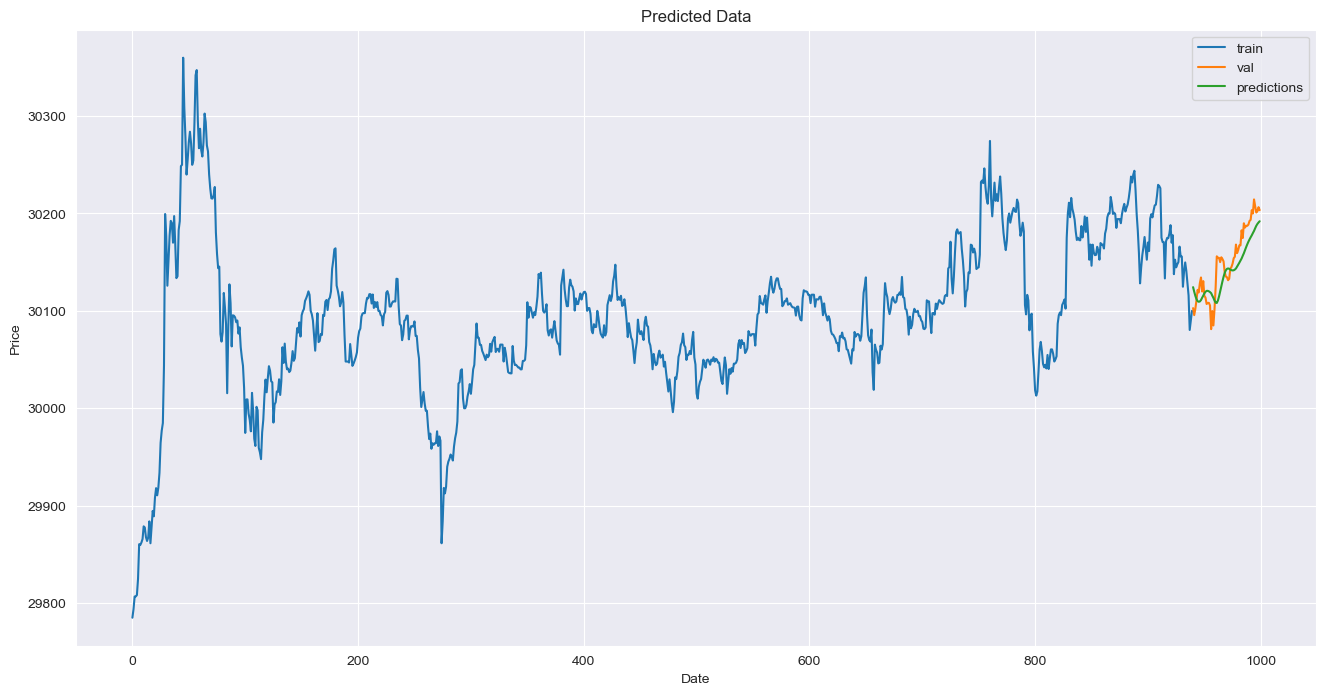

In [68]:
data = data.filter(['close'])
train = data[:train_len]
validation = data[train_len:]
validation['predictions'] = preds
plt.figure(figsize=(16, 8))
plt.title('Predicted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train)
plt.plot(validation[['close', 'predictions']])
plt.legend(['train', 'val', 'predictions'], loc='upper right')
plt.show()